# Analyse bivariée: génération, genre, continent, field of work

Pour l'importation des données, voir ces carnets sparqlbook:
* [Occupations](../../sparqlbooks/wdt_import_occupations.sparqlbook.md)
* [Field](../../sparqlbooks/wdt_import_fields.sparqlbook.md)
* [Continents](../../sparqlbooks/wdt_import_citizenships.sparqlbook.md)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](../../sparqlbooks/wdt_available_information.sparqlbook.md )




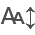

In [326]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




In [327]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [328]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [329]:
## define SPARQL enpoint
endpoint = "https://ag1mdzaeq7qnj00h.allegrograph.cloud/repositories/archivist"

In [331]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            ( GROUP_CONCAT(DISTINCT ?genderLabel; separator=", ") AS ?genders ) 
            ( GROUP_CONCAT(DISTINCT ?countryLabel; separator=", ") AS ?countries )
            ( GROUP_CONCAT(DISTINCT ?continentLabel; separator=", ") AS ?continents )
            ( GROUP_CONCAT(DISTINCT ?fieldLabel; separator=", ") AS ?fields )
WHERE {
    GRAPH <https://github.com/mroylem/archivist/blob/main/Wikidata/graph/imported-data.md>
        {?s wdt:P21 ?gender;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?gender rdfs:label ?genderLabel.
        ?country rdfs:label ?countryLabel.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        OPTIONAL {  ?s wdt:P101 ?field.
                    ?field rdfs:label ?fieldLabel.}

        ## Excluding Africa, Eurasia, Australia and Oceania insular
        FILTER ( ?continent NOT IN (wd:Q538, wd:Q3960, wd:Q5401))
          }
}
GROUP BY ?s
"""

In [335]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [336]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

5082


[['http://www.wikidata.org/entity/Q54553381',
  'Waverly Lowell',
  '1951',
  'female',
  'United States',
  'North America',
  'library science, history of architecture, curating, archival science'],
 ['http://www.wikidata.org/entity/Q20164843',
  'Günter Buchstab',
  '1944',
  'male',
  'Germany',
  'Europe',
  ''],
 ['http://www.wikidata.org/entity/Q2637717',
  'Albert Bruckner',
  '1904',
  'male',
  'Switzerland',
  'Europe',
  'archival science, history, medieval studies, palaeography']]

In [337]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'gender', 'countries', 'continents', 'fields']
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,fields
0,http://www.wikidata.org/entity/Q54553381,Waverly Lowell,1951,female,United States,North America,"library science, history of architecture, cura..."
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,male,Germany,Europe,
2,http://www.wikidata.org/entity/Q2637717,Albert Bruckner,1904,male,Switzerland,Europe,"archival science, history, medieval studies, p..."
3,http://www.wikidata.org/entity/Q5783602,Conrado Morterero Simón,1915,male,Spain,Europe,
4,http://www.wikidata.org/entity/Q15429548,Karlheinz Geppert,1955,male,Germany,Europe,


In [338]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [341]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    5082 non-null   object
 1   personLabel  5082 non-null   object
 2   birthYear    5082 non-null   int64 
 3   gender       5082 non-null   object
 4   countries    5082 non-null   object
 5   continents   5082 non-null   object
 6   fields       5082 non-null   object
dtypes: int64(1), object(6)
memory usage: 278.1+ KB


In [342]:
### Store to CSV
f_path = 'data/df_continent_fields_20250406.csv'
df_p.to_csv(f_path)

## Coder les continents et afficher leur distribution

In [343]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0    North America
1           Europe
2           Europe
3           Europe
4           Europe
Name: continents, dtype: object


In [344]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))



                                0
continents                       
Europe                       4548
North America                 288
Europe, Asia                   70
Asia                           37
Oceania                        24
South America                  21
Africa                         20
Asia, Europe, North America    14
Asia, Europe                   14
North America, Europe, Asia    12


In [345]:
### Créer une fonction de codage
def codeContinents(continents):
    
    if 'Europe, Asia' in continents:
        output = 'Eurasia'
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [346]:
### Tester la fonction
print(codeContinents('Oceania, North America, Africa'))

Africa


In [347]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,fields,contCode
0,http://www.wikidata.org/entity/Q54553381,Waverly Lowell,1951,female,United States,North America,"library science, history of architecture, cura...",NorthAmerica
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,male,Germany,Europe,,Europe
2,http://www.wikidata.org/entity/Q2637717,Albert Bruckner,1904,male,Switzerland,Europe,"archival science, history, medieval studies, p...",Europe


In [348]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
Africa              20
SouthAmerica        21
Oceania             24
Asia                37
Eurasia             88
NorthAmerica       289
Europe            4603


In [349]:
### How to handle data about Russians
df_p[df_p.countries.str.contains('Russi')].head(7)

,personUri,personLabel,birthYear,gender,countries,continents,fields,contCode
36,http://www.wikidata.org/entity/Q4413678,Q4413678,1856,male,Russian Empire,North America,"archival science, archaeography, regional history",NorthAmerica
37,http://www.wikidata.org/entity/Q15066779,Viktor Zaytsev,1951,male,"Soviet Union, Russia","Europe, Asia",,Eurasia
58,http://www.wikidata.org/entity/Q133874877,Q133874877,1855,male,"Russian Empire, Soviet Union","North America, Europe, Asia",,Eurasia
66,http://www.wikidata.org/entity/Q113775179,Vjačeslav V. Šapošnik,1967,male,Russia,Europe,"history, history of Christianity, cultural his...",Europe
84,http://www.wikidata.org/entity/Q113775078,Irmgard Stamm,1957,female,"Russia, Germany",Europe,"pedagogy, cultural studies, European ethnology...",Europe
170,http://www.wikidata.org/entity/Q4299404,Lev Mozdalevsky,1902,male,"Soviet Union, Russian Empire","Asia, Europe, North America","Pushkin studies, history of literature, archiv...",Europe
177,http://www.wikidata.org/entity/Q4080959,Pavel Vladimirovich Bezobrazov,1859,male,Russian Empire,North America,,NorthAmerica


In [350]:
 
### Regrouper et compter les personnes issues de Russie
df_contCode = df_p[df_p.countries.str.contains('ussi')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
NorthAmerica        20
Eurasia             44
Europe              48


In [351]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,fields,contCode
97,http://www.wikidata.org/entity/Q34663319,Maurice de Tribolet,1939,male,Switzerland,Europe,,Europe
98,http://www.wikidata.org/entity/Q113806187,Domenico Corsi,1905,male,"Italy, Kingdom of Italy",Europe,,Europe
99,http://www.wikidata.org/entity/Q35979776,Arlette Playoust,1937,female,France,Europe,,Europe
100,http://www.wikidata.org/entity/Q9302569,Radosław Gaziński,1960,male,Poland,Europe,,Europe


In [352]:
# Noter la personne index 116, František Doutlík trouvé grâce à la propriété 'field'
df_p.iloc[ 111:118 :  ]

,personUri,personLabel,birthYear,gender,countries,continents,fields,contCode
111,http://www.wikidata.org/entity/Q59629825,Carmen Crespo Nogueira,1924,female,Spain,Europe,,Europe
112,http://www.wikidata.org/entity/Q24026882,Florian Watzl,1870,male,Austria–Hungary,Europe,,Europe
113,http://www.wikidata.org/entity/Q104552887,María Victoria González Mateos,1908,female,Spain,Europe,,Europe
114,http://www.wikidata.org/entity/Q1359809,Ernst Posner,1892,male,"Germany, United States","Europe, North America",,Europe
115,http://www.wikidata.org/entity/Q17484910,Michael Crone,1985,male,Germany,Europe,,Europe
116,http://www.wikidata.org/entity/Q15429741,Mahesh Chandra Regmi,1929,male,Nepal,Asia,,Asia
117,http://www.wikidata.org/entity/Q6233875,"John Francis Charles, 7th Count de Salis-Soglio",1864,male,"United Kingdom, United Kingdom of Great Britai...",Europe,,Europe


### Distribution des continents: représentation graphique

In [353]:
### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']

df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
Africa,20,0.39
SouthAmerica,21,0.41
Oceania,24,0.47
Asia,37,0.73
Eurasia,88,1.73
NorthAmerica,289,5.69
Europe,4603,90.57


In [354]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,Europe,NorthAmerica,Eurasia,Asia,Oceania,SouthAmerica,Africa
frequence,90.57,5.69,1.73,0.73,0.47,0.41,0.39


In [355]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique
col_palette = [
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral: Asia
    "#F6E58D",  # Light Yellow :SouthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#E3D4AD",  # Desert Sand : Eurasia
    "#A3C1DA",  # Light Blue : Africa    

]


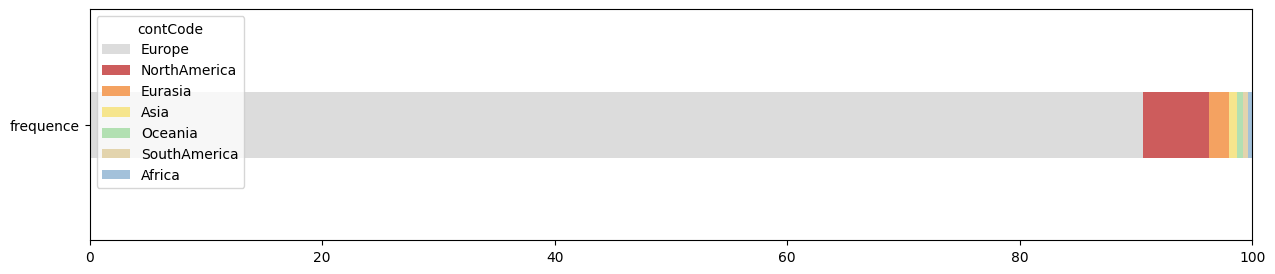

In [356]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette, width=0.2, xlim=[0,100])

### Codage par période de vingt-cinq ans

In [357]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1751, 2025, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1901, 1926, 1951, 1976, 2001] 10


In [358]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [359]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q54553381,Waverly Lowell,1951,female,United States,North America,"library science, history of architecture, cura...",NorthAmerica,1951-1975
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,male,Germany,Europe,,Europe,1926-1950
2,http://www.wikidata.org/entity/Q2637717,Albert Bruckner,1904,male,Switzerland,Europe,"archival science, history, medieval studies, p...",Europe,1901-1925


In [360]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25', observed=True).size()
print(naissances_per)

per_25
1851-1875     645
1876-1900     864
1901-1925    1169
1926-1950    1216
1951-1975    1002
1976-2000     186
dtype: int64


### Comparer période et continent

In [372]:


### Tableau de contingence
X = "contCode"
Y = "per_25"  # "0"

ddf = df_p[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1851-1875,0,0,7,598,38,0,2,645
1876-1900,0,1,11,817,30,4,1,864
1901-1925,6,11,19,1062,67,3,1,1169
1926-1950,2,15,27,1065,91,8,8,1216
1951-1975,12,8,21,896,51,7,7,1002
1976-2000,0,2,3,165,12,2,2,186
Total,20,37,88,4603,289,24,21,5082


In [373]:
### Modifiy column order
print(ddf.columns.to_list())
ddf = ddf[['Europe', 'Eurasia',  'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica', 'Total']]
ddf

['Africa', 'Asia', 'Eurasia', 'Europe', 'NorthAmerica', 'Oceania', 'SouthAmerica', 'Total']


contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1851-1875,598,7,38,0,0,0,2,645
1876-1900,817,11,30,1,0,4,1,864
1901-1925,1062,19,67,11,6,3,1,1169
1926-1950,1065,27,91,15,2,8,8,1216
1951-1975,896,21,51,8,12,7,7,1002
1976-2000,165,3,12,2,0,2,2,186
Total,4603,88,289,37,20,24,21,5082


In [374]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#E3D4AD",  # Desert Sand : Eurasia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#A3C1DA",  # Light Blue : Africa
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


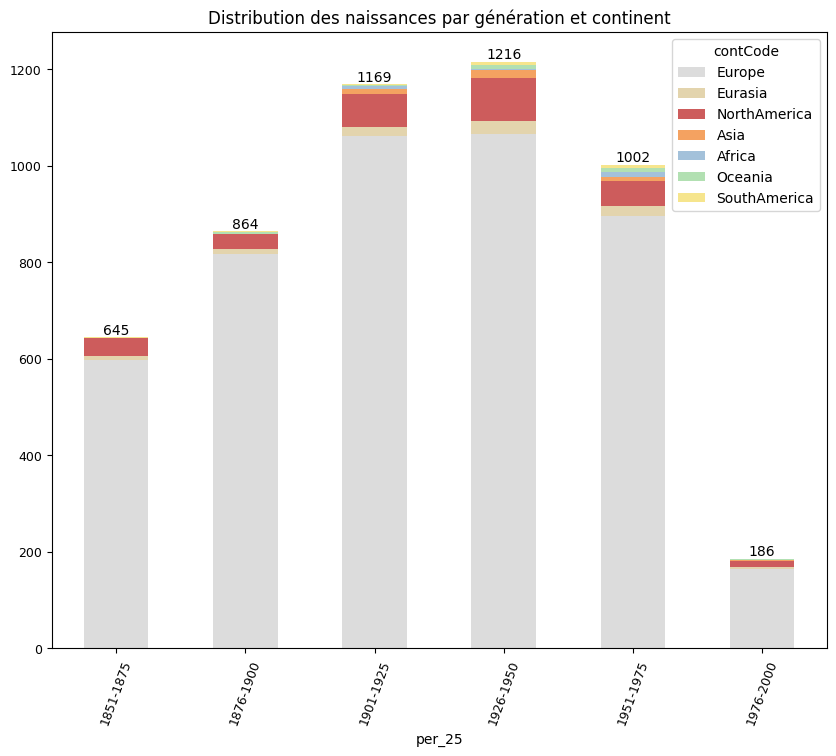

In [375]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()

## Analyse bivariée: périodes, continents



On observe un fort déséquilibre entre les périodes et les continents. On peut présenter ce fait, par exemple en relevant le développement des États Unis et de la Russie (Eurasie) dès le milieu du 19e siècle. Mais on ne peut pas utiliser les données comme telles pour une analyse, il faudra restreindre l'analyse à la partie du tableau pour laquelle les effectis sont suffisants.



In [376]:
ddf

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1851-1875,598,7,38,0,0,0,2,645
1876-1900,817,11,30,1,0,4,1,864
1901-1925,1062,19,67,11,6,3,1,1169
1926-1950,1065,27,91,15,2,8,8,1216
1951-1975,896,21,51,8,12,7,7,1002
1976-2000,165,3,12,2,0,2,2,186
Total,4603,88,289,37,20,24,21,5082


In [377]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddf.iloc[3:10,:-1].copy(deep=True)
D



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1926-1950,1065,27,91,15,2,8,8
1951-1975,896,21,51,8,12,7,7
1976-2000,165,3,12,2,0,2,2
Total,4603,88,289,37,20,24,21


In [378]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 4 , 7 ), effectif: 7486 , nombre max. facteurs: 3


In [379]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 33.81 , dof : 18
p-value : 0.013281545528333388
phi2 = inertie (variance totale) : 0.004516848868006894
Cramer:  0.038802271703286026


In [380]:
### Situation à l'indépendance

indep = pd.DataFrame(expected)
indep.columns = D.columns
indep.index = D.index
indep.round(0).astype(int)

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1926-1950,1093,23,72,10,6,7,6
1951-1975,901,19,59,8,5,5,5
1976-2000,167,3,11,2,1,1,1
Total,4568,94,301,42,23,28,26


In [381]:
D

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1926-1950,1065,27,91,15,2,8,8
1951-1975,896,21,51,8,12,7,7
1976-2000,165,3,12,2,0,2,2
Total,4603,88,289,37,20,24,21


In [382]:


### Écart à l'indépendance:
# différence en effectifs entre le théorique et l'observé
#  Valeurs arrondies
### Doc. :
#   Bennani, p.30
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (D-indep)
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.round(0).astype(int))



contCode   Europe  Eurasia  NorthAmerica  Asia  Africa  Oceania  SouthAmerica
per_25                                                                       
1926-1950     -28        4            19     5      -4        1             2
1951-1975      -5        2            -8     0       7        2             2
1976-2000      -2        0             1     0      -1        1             1
Total          35       -6           -12    -5      -3       -4            -5


In [383]:


### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
residus_ponderes



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1926-1950,-0.85,0.93,2.24,1.55,-1.50,0.52,0.74
1951-1975,-0.16,0.56,-1.08,-0.10,3.49,0.65,0.85
1976-2000,-0.17,-0.24,0.30,0.37,-0.92,0.97,1.09
Total,0.52,-0.65,-0.68,-0.78,-0.64,-0.73,-0.94


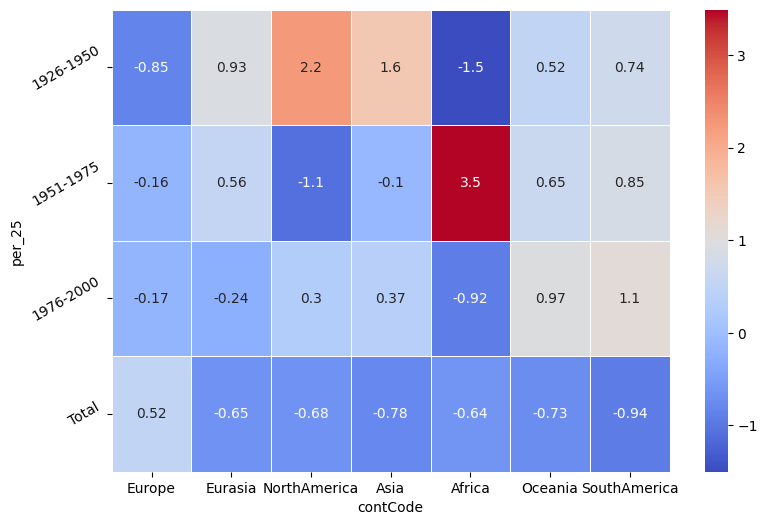

In [384]:
### Résidus pondérés
tableau = residus_ponderes

fig, ax = plt.subplots(figsize=(9,6))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()



### En excluant l'Europe ou choisissant les pays

In [386]:
print(D.columns.to_list())
D.iloc[ : , 1:]

['Europe', 'Eurasia', 'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica']


contCode,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,
1926-1950,27,91,15,2,8,8
1951-1975,21,51,8,12,7,7
1976-2000,3,12,2,0,2,2
Total,88,289,37,20,24,21


In [387]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D.iloc[ : , 1:])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[ : , 1:], method='cramer')
print('Cramer: ', vc)

Chi2 : 21.73 , dof : 15
p-value : 0.1151057295465081
phi2 = inertie (variance totale) : 0.0029026350954661213
Cramer:  0.09781660047875482


In [389]:
D[['Europe', 'Asia', 'Eurasia', 'NorthAmerica', 'SouthAmerica']]

contCode,Europe,Asia,Eurasia,NorthAmerica,SouthAmerica
per_25,,,,,
1926-1950,1065,15,27,91,8
1951-1975,896,8,21,51,7
1976-2000,165,2,3,12,2
Total,4603,37,88,289,21


In [390]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D[['Europe', 'Eurasia']])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D[['Europe', 'Eurasia']], method='cramer')
print('Cramer: ', vc)

Chi2 : 2.0 , dof : 3
p-value : 0.571981599543596
phi2 = inertie (variance totale) : 0.0002674390452364501
Cramer:  0.017073484896851458


## Continent et genre

In [391]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q54553381,Waverly Lowell,1951,female,United States,North America,"library science, history of architecture, cura...",NorthAmerica,1951-1975
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,male,Germany,Europe,,Europe,1926-1950
2,http://www.wikidata.org/entity/Q2637717,Albert Bruckner,1904,male,Switzerland,Europe,"archival science, history, medieval studies, p...",Europe,1901-1925
3,http://www.wikidata.org/entity/Q5783602,Conrado Morterero Simón,1915,male,Spain,Europe,,Europe,1901-1925
4,http://www.wikidata.org/entity/Q15429548,Karlheinz Geppert,1955,male,Germany,Europe,,Europe,1951-1975


In [392]:


### Tableau de contingence
X = "contCode"
Y = "gender"  # "0"

ddgc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
gender,,,,,,,,
female,4,7,17,983,85,10,7,1113
male,16,30,71,3619,200,14,13,3963
Total,20,37,88,4602,285,24,20,5076


### Créer la fonction

In [393]:
def bivariee_stats(D):
    # Supprimer lignes et colonnes entières de zéros
    D = D.loc[~(D==0).all(axis=1), :]   # enlève lignes 100% zéro
    D = D.loc[:, ~(D==0).all(axis=0)]   # enlève colonnes 100% zéro
    
    n = D.to_numpy().sum()  # total effectif
    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=(9,3))         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

In [394]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddgc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
gender,,,,,,,
female,4,7,17,983,85,10,7
male,16,30,71,3619,200,14,13


Chi2 : 19.3 , dof : 6
p-value : 0.0036927241084431404
phi2 = inertie (variance totale) : 0.003801306634253181
Cramer:  0.06165473732206781


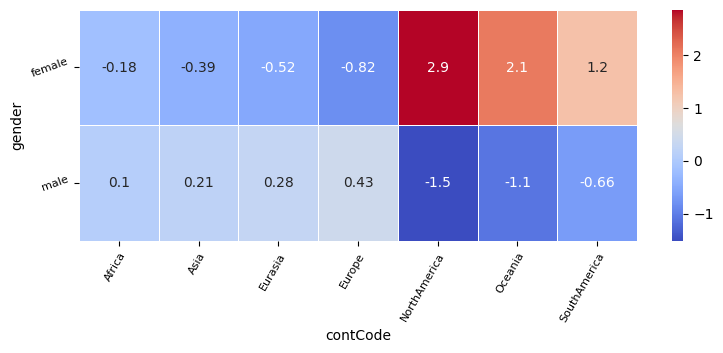

In [395]:
bivariee_stats(D)

### Genre et continent par époque

In [396]:
df_p['genre_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.gender, axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q54553381,Waverly Lowell,1951,female,United States,North America,"library science, history of architecture, cura...",NorthAmerica,1951-1975,NorthAmerica_female
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,male,Germany,Europe,,Europe,1926-1950,Europe_male
2,http://www.wikidata.org/entity/Q2637717,Albert Bruckner,1904,male,Switzerland,Europe,"archival science, history, medieval studies, p...",Europe,1901-1925,Europe_male
3,http://www.wikidata.org/entity/Q5783602,Conrado Morterero Simón,1915,male,Spain,Europe,,Europe,1901-1925,Europe_male
4,http://www.wikidata.org/entity/Q15429548,Karlheinz Geppert,1955,male,Germany,Europe,,Europe,1951-1975,Europe_male


In [397]:


### Tableau de contingence
X = "genre_cont"
Y = "per_25"  # "0"

ddgcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgcp



genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male,Total
per_25,,,,,,,,,,,,,,,
1851-1875,0,0,0,0,0,7,7,591,3,35,0,0,0,2,645
1876-1900,0,0,0,1,1,10,64,753,12,18,2,2,0,1,864
1901-1925,0,6,0,11,6,13,219,843,22,45,2,1,0,1,1169
1926-1950,1,1,5,10,5,22,279,785,26,64,5,3,3,5,1214
1951-1975,3,9,2,6,5,16,343,553,14,34,1,6,3,3,998
1976-2000,0,0,0,2,0,3,71,94,8,4,0,2,1,1,186
Total,4,16,7,30,17,71,983,3619,85,200,10,14,7,13,5076


In [398]:
### Limiter à la période significative, 20 siècle
D = ddgcp.iloc[4:-1,:-1].copy(deep=True)
D


genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male
per_25,,,,,,,,,,,,,,
1951-1975,3,9,2,6,5,16,343,553,14,34,1,6,3,3
1976-2000,0,0,0,2,0,3,71,94,8,4,0,2,1,1


Chi2 : 14.48 , dof : 13
p-value : 0.34089983110744876
phi2 = inertie (variance totale) : 0.012230096943872646
Cramer:  0.11058976871244756


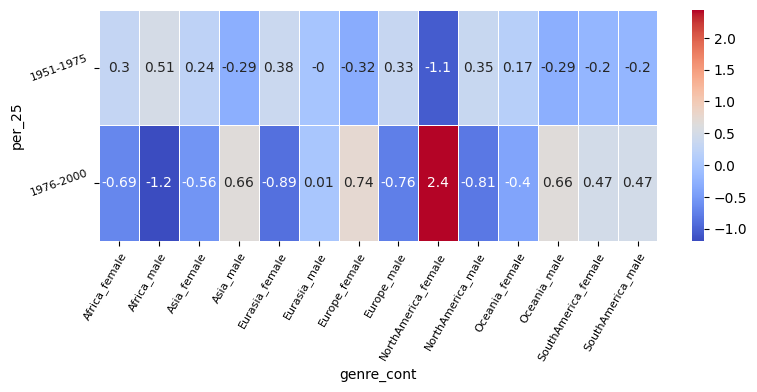

In [399]:
## Appliquer la fonction
bivariee_stats(D)

#### Explorer les résultats et commenter

In [400]:
df_pef = df_p[df_p['genre_cont'] == 'Europe_female']
print(len(df_pef))

983


In [401]:
print(df_pef.groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
France            229
Spain             128
Germany           113
Italy             109
Czechoslovakia     64
Poland             40
Hungary            35
Austria            22
Czech Republic     22
United Kingdom     19
dtype: int64


In [402]:
print(df_pef[df_pef.per_25 == '1976-2000'].groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
France                            24
Italy                             15
Germany                           12
Hungary                            4
Belarus                            3
Austria                            3
Czech Republic                     2
Poland                             2
Estonia                            1
Czech Republic, Czechoslovakia     1
dtype: int64


In [403]:
fff = df_pef[(df_pef.per_25 == '1976-2000') & (df_pef.countries.str.contains('Germany'))]
print(len(fff))
fff.head()

12


,personUri,personLabel,birthYear,gender,countries,continents,fields,contCode,per_25,genre_cont
157,http://www.wikidata.org/entity/Q95187256,Julia Kahleyß,1978,female,Germany,Europe,,Europe,1976-2000,Europe_female
972,http://www.wikidata.org/entity/Q113835214,Claudia Seyfried,1981,female,Germany,Europe,,Europe,1976-2000,Europe_female
1057,http://www.wikidata.org/entity/Q113823328,Hannah Rita Laue,1983,female,Germany,Europe,,Europe,1976-2000,Europe_female
1367,http://www.wikidata.org/entity/Q113844641,Felicitas Söhner,1976,female,Germany,Europe,,Europe,1976-2000,Europe_female
1579,http://www.wikidata.org/entity/Q113845870,Carina Schmidt,1981,female,Germany,Europe,,Europe,1976-2000,Europe_female


## Continent et discipline

In [404]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q54553381,Waverly Lowell,1951,female,United States,North America,"library science, history of architecture, cura...",NorthAmerica,1951-1975,NorthAmerica_female
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,male,Germany,Europe,,Europe,1926-1950,Europe_male
2,http://www.wikidata.org/entity/Q2637717,Albert Bruckner,1904,male,Switzerland,Europe,"archival science, history, medieval studies, p...",Europe,1901-1925,Europe_male
3,http://www.wikidata.org/entity/Q5783602,Conrado Morterero Simón,1915,male,Spain,Europe,,Europe,1901-1925,Europe_male
4,http://www.wikidata.org/entity/Q15429548,Karlheinz Geppert,1955,male,Germany,Europe,,Europe,1951-1975,Europe_male


In [405]:
def code_discipline(col: str) -> str:
    col = col.lower()  # normalize case
    
    mapping = {
        "history of architecture": "history",
        "regional history": "history",
        "history": "history",
        "library science": "library",
        "library": "library",
        "palaeography": "palaeography",
        "archival science": "archival",
        "archival": "archival",
        "science": "science",
        "studies": "studies",
    }
    
    for key, value in mapping.items():
        if key in col:
            return value
    return "other"


In [406]:
df_p['code_discipline'] = df_p.apply(lambda x: code_discipline(x.fields), axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q54553381,Waverly Lowell,1951,female,United States,North America,"library science, history of architecture, cura...",NorthAmerica,1951-1975,NorthAmerica_female,history
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,male,Germany,Europe,,Europe,1926-1950,Europe_male,other
2,http://www.wikidata.org/entity/Q2637717,Albert Bruckner,1904,male,Switzerland,Europe,"archival science, history, medieval studies, p...",Europe,1901-1925,Europe_male,history
3,http://www.wikidata.org/entity/Q5783602,Conrado Morterero Simón,1915,male,Spain,Europe,,Europe,1901-1925,Europe_male,other
4,http://www.wikidata.org/entity/Q15429548,Karlheinz Geppert,1955,male,Germany,Europe,,Europe,1951-1975,Europe_male,other


In [407]:
df_p.groupby('code_discipline').size()

code_discipline
archival         117
history          701
library           37
other           4178
palaeography      31
science            3
studies           15
dtype: int64

In [408]:


### Tableau de contingence
X = "contCode"
Y = "code_discipline"  # "0"

dddc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
archival,0,1,3,104,9,0,0,117
history,0,3,31,641,26,0,0,701
library,0,0,0,27,8,0,0,35
other,19,32,54,3785,240,24,20,4174
palaeography,0,0,0,31,0,0,0,31
science,1,1,0,0,1,0,0,3
studies,0,0,0,14,1,0,0,15
Total,20,37,88,4602,285,24,20,5076


In [409]:
### Profils des lignes
# axis=0 pour les colonnes

dddc_pl = dddc.apply(lambda x: (x/sum(x)*100*2).round(1), axis=1) 
dddc_pl

contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
archival,0.0,0.9,2.6,88.9,7.7,0.0,0.0,100.0
history,0.0,0.4,4.4,91.4,3.7,0.0,0.0,100.0
library,0.0,0.0,0.0,77.1,22.9,0.0,0.0,100.0
other,0.5,0.8,1.3,90.7,5.7,0.6,0.5,100.0
palaeography,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0
science,33.3,33.3,0.0,0.0,33.3,0.0,0.0,100.0
studies,0.0,0.0,0.0,93.3,6.7,0.0,0.0,100.0
Total,0.4,0.7,1.7,90.7,5.6,0.5,0.4,100.0


In [410]:
### Adapter à l'ordre des colonnes
col_palette_2 = [
    "#A3C1DA",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#E3D4AD",  # Desert Sand : Eurasia
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


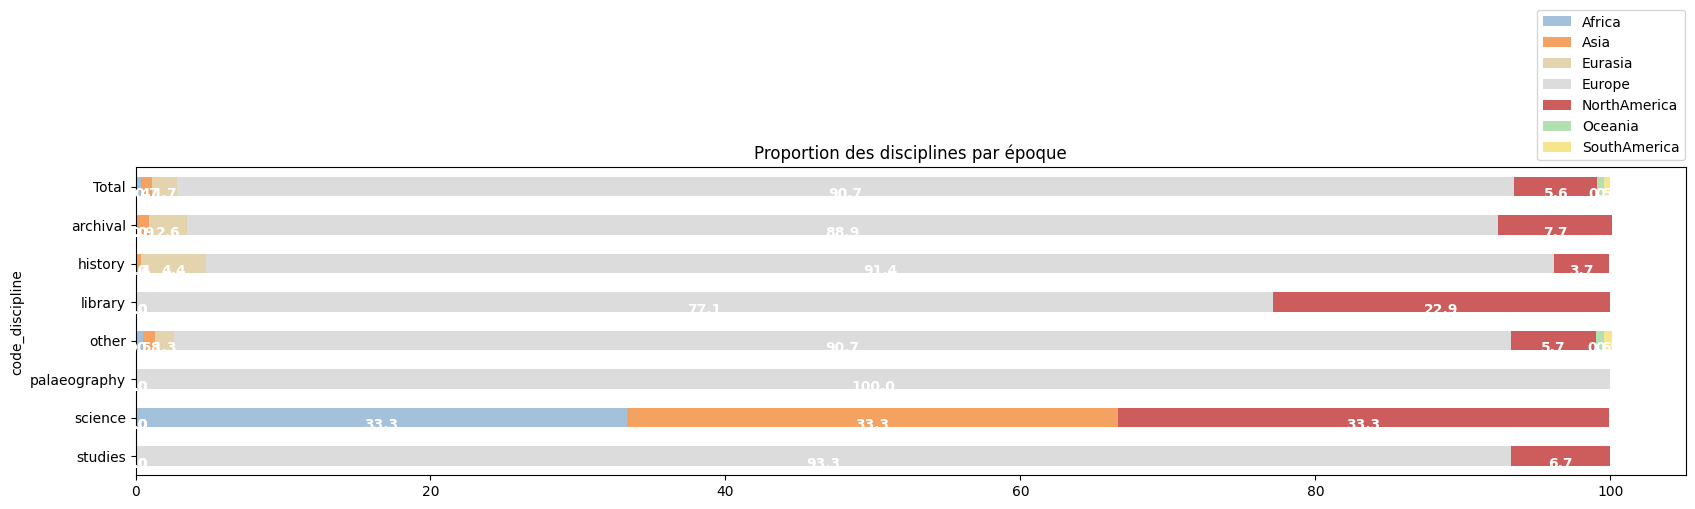

In [411]:


### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

ax = dddc_pl.iloc[:, :-1].sort_index(ascending=False).plot(kind="barh",
                    stacked=True, figsize=(20,4), title='Proportion des disciplines par époque',
                    color=col_palette_2
                    )

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

for p in ax.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax.legend(bbox_to_anchor=(0.9, 1))

plt.show()

In [412]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = dddc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
code_discipline,,,,,,,
archival,0,1,3,104,9,0,0
history,0,3,31,641,26,0,0
library,0,0,0,27,8,0,0
other,19,32,54,3785,240,24,20
palaeography,0,0,0,31,0,0,0
science,1,1,0,0,1,0,0
studies,0,0,0,14,1,0,0


Chi2 : 210.99 , dof : 36
p-value : 1.2687333108350121e-26
phi2 = inertie (variance totale) : 0.04156619640785621
Cramer:  0.08323280243575466


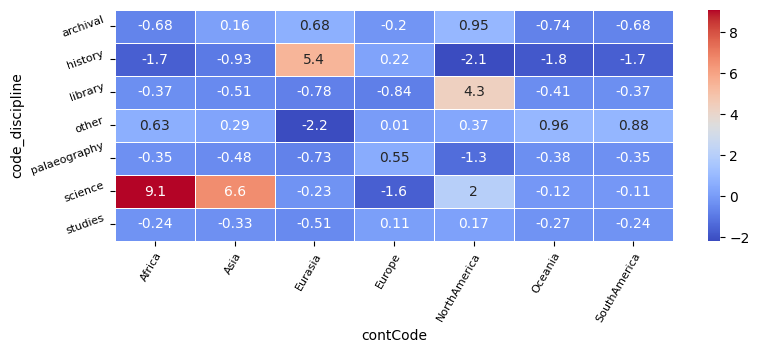

In [413]:
## Appliquer la fonction
bivariee_stats(D)

## Discipline et continent par époque

In [414]:
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q54553381,Waverly Lowell,1951,female,United States,North America,"library science, history of architecture, cura...",NorthAmerica,1951-1975,NorthAmerica_female,history
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,male,Germany,Europe,,Europe,1926-1950,Europe_male,other


In [415]:
df_p['disc_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.code_discipline, axis=1)
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q54553381,Waverly Lowell,1951,female,United States,North America,"library science, history of architecture, cura...",NorthAmerica,1951-1975,NorthAmerica_female,history,NorthAmerica_history
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,male,Germany,Europe,,Europe,1926-1950,Europe_male,other,Europe_other


In [416]:
### Tableau de contingence
X = "disc_cont"
Y = "per_25"  # "0"

dddcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddcp

disc_cont,Africa_other,Africa_science,Asia_archival,Asia_history,Asia_other,Asia_science,Eurasia_archival,Eurasia_history,Eurasia_other,Europe_archival,...,Europe_studies,NorthAmerica_archival,NorthAmerica_history,NorthAmerica_library,NorthAmerica_other,NorthAmerica_science,NorthAmerica_studies,Oceania_other,SouthAmerica_other,Total
per_25,,,,,,,,,,,,,,,,,,,,,
1851-1875,0,0,0,0,0,0,0,2,5,8,...,0,1,8,0,29,0,0,0,2,645
1876-1900,0,0,0,0,1,0,0,2,9,20,...,1,1,3,1,25,0,0,4,1,864
1901-1925,6,0,0,0,11,0,0,6,13,20,...,5,1,3,1,62,0,0,3,1,1169
1926-1950,2,0,1,1,13,0,3,10,14,26,...,4,4,7,2,76,0,1,8,8,1214
1951-1975,11,1,0,2,5,1,0,11,10,24,...,4,1,4,3,39,1,0,7,6,998
1976-2000,0,0,0,0,2,0,0,0,3,6,...,0,1,1,1,9,0,0,2,2,186
Total,19,1,1,3,32,1,3,31,54,104,...,14,9,26,8,240,1,1,24,20,5076


In [417]:
### Limiter à la période significative, 20 siècle
D = dddcp.iloc[4:-1,:-1].copy(deep=True)
D


disc_cont,Africa_other,Africa_science,Asia_archival,Asia_history,Asia_other,Asia_science,Eurasia_archival,Eurasia_history,Eurasia_other,Europe_archival,...,Europe_palaeography,Europe_studies,NorthAmerica_archival,NorthAmerica_history,NorthAmerica_library,NorthAmerica_other,NorthAmerica_science,NorthAmerica_studies,Oceania_other,SouthAmerica_other
per_25,,,,,,,,,,,,,,,,,,,,,
1951-1975,11,1,0,2,5,1,0,11,10,24,...,3,4,1,4,3,39,1,0,7,6
1976-2000,0,0,0,0,2,0,0,0,3,6,...,1,0,1,1,1,9,0,0,2,2


Chi2 : 13.99 , dof : 19
p-value : 0.7843827794754967
phi2 = inertie (variance totale) : 0.011814299707979092
Cramer:  0.10869360472437692


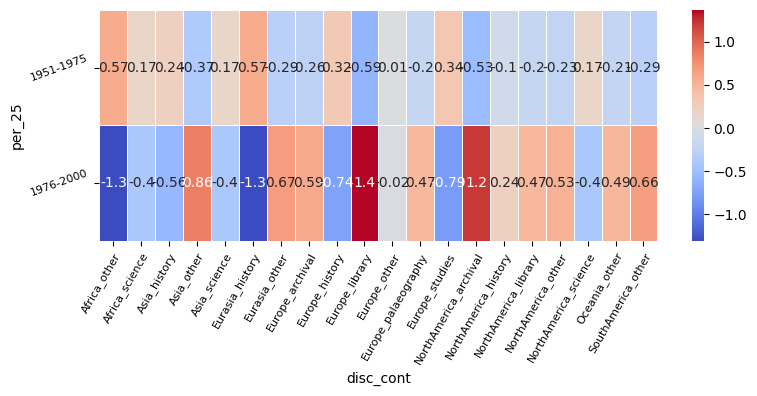

In [418]:
## Appliquer la fonction
bivariee_stats(D)